## Advevrsarial Patch On CIFAR10 Using ResNet


In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Prepare dataset

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
combined_test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)


# Get targets from the test data for stratification
targets = combined_test_data.targets

# Stratified split for validation and test sets from the original test dataset
sss_test_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Split 50/50
valid_idx, test_idx = next(sss_test_valid.split(np.zeros(len(targets)), targets))

# Convert indices to actual Subset for validation and test datasets
valid_dataset = Subset(combined_test_data, valid_idx)
test_dataset = Subset(combined_test_data, test_idx)

# Prepare data loaders
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Total number of samples in the complete dataset
total_samples = len(train_loader) + len(valid_loader) + len(test_loader)

# Assuming the splits have been previously calculated:
# Sizes of each dataset split
train_size = len(train_loader)
test_size = len(test_loader)
validation_size = len(valid_loader)

# Calculate proportions
train_proportion = train_size / total_samples
test_proportion = test_size / total_samples
validation_proportion = validation_size / total_samples

# Print the proportions
print(f"Training Data Proportion: {train_proportion:.2f}")
print(f"Test Data Proportion: {test_proportion:.2f}")
print(f"Validation Data Proportion: {validation_proportion:.2f}")


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

==> Preparing data..
Training Data Proportion: 0.83
Test Data Proportion: 0.08
Validation Data Proportion: 0.08


### Model Definiation

In [3]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion      
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out



In [4]:
ResNet18 = ResNet(BasicBlock, [2,2,2,2])


if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

In [5]:

# Load Pretrained model
ResNet18.load_state_dict(torch.load('ResNet18_20250419.pt'))

print("Pretrained ResNet18 loaded and ready!")

# Step 4: Move model to device and eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ResNet18 = ResNet18.to(device)
ResNet18.eval()


Pretrained ResNet18 loaded and ready!


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

### Adversarial Patch

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
     

In [7]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, train_loader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    success = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                success += (predicted == target_class).sum().item()
            else:
                success += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    successR = 100 * success / total
    print(f"Attack Success Rate: {successR:.2f}%")

# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            # Display only if the original prediction is correct and the patched prediction is incorrect
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                # Normalize back to [0, 1] range for visualization
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                # Plot images with a fixed size to match CIFAR-10
                fig, axes = plt.subplots(1, 2, figsize=(5, 5))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")
                axes[0].axis('off')

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")
                axes[1].axis('off')

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return
     


Training for patch size: (3, 3)
Epoch 1/20, Loss: 9.5122
Epoch 2/20, Loss: 5.1578
Epoch 3/20, Loss: 4.6055
Epoch 4/20, Loss: 4.5293
Epoch 5/20, Loss: 4.4789
Epoch 6/20, Loss: 4.4780
Epoch 7/20, Loss: 4.4416
Epoch 8/20, Loss: 4.4163
Epoch 9/20, Loss: 4.4133
Epoch 10/20, Loss: 4.3718
Epoch 11/20, Loss: 4.3451
Epoch 12/20, Loss: 4.3556
Epoch 13/20, Loss: 4.3164
Epoch 14/20, Loss: 4.3088
Epoch 15/20, Loss: 4.2973
Epoch 16/20, Loss: 4.3087
Epoch 17/20, Loss: 4.2977
Epoch 18/20, Loss: 4.2972
Epoch 19/20, Loss: 4.3060
Epoch 20/20, Loss: 4.2679
Visualizing patch of size (3, 3)


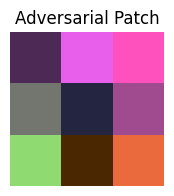

Attack Success Rate: 89.60%


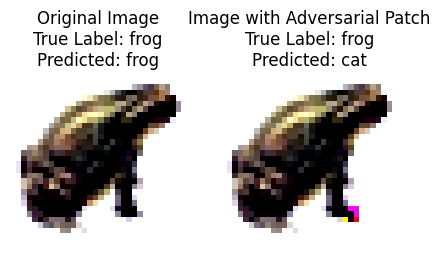

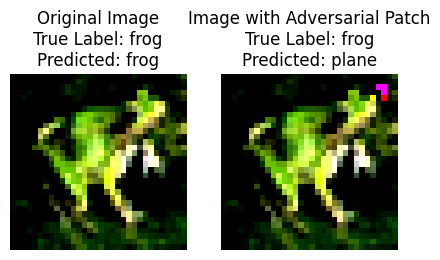


Training for patch size: (5, 5)
Epoch 1/20, Loss: 8.8762
Epoch 2/20, Loss: 5.0640
Epoch 3/20, Loss: 4.6460
Epoch 4/20, Loss: 4.5312
Epoch 5/20, Loss: 4.4254
Epoch 6/20, Loss: 4.4142
Epoch 7/20, Loss: 4.3574
Epoch 8/20, Loss: 4.3526
Epoch 9/20, Loss: 4.3305
Epoch 10/20, Loss: 4.3218
Epoch 11/20, Loss: 4.3139
Epoch 12/20, Loss: 4.3046
Epoch 13/20, Loss: 4.2945
Epoch 14/20, Loss: 4.2883
Epoch 15/20, Loss: 4.2861
Epoch 16/20, Loss: 4.2705
Epoch 17/20, Loss: 4.2743
Epoch 18/20, Loss: 4.2578
Epoch 19/20, Loss: 4.2616
Epoch 20/20, Loss: 4.2396
Visualizing patch of size (5, 5)


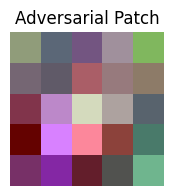

Attack Success Rate: 89.36%


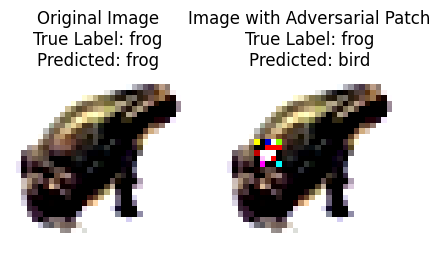

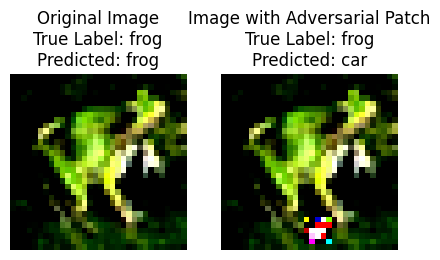


Training for patch size: (7, 7)
Epoch 1/20, Loss: 8.7244
Epoch 2/20, Loss: 5.3916
Epoch 3/20, Loss: 4.5864
Epoch 4/20, Loss: 4.4885
Epoch 5/20, Loss: 4.4044
Epoch 6/20, Loss: 4.3369
Epoch 7/20, Loss: 4.2952
Epoch 8/20, Loss: 4.2498
Epoch 9/20, Loss: 4.2322
Epoch 10/20, Loss: 4.2374
Epoch 11/20, Loss: 4.2096
Epoch 12/20, Loss: 4.1808
Epoch 13/20, Loss: 4.1860
Epoch 14/20, Loss: 4.1893
Epoch 15/20, Loss: 4.1848
Epoch 16/20, Loss: 4.1670
Epoch 17/20, Loss: 4.1486
Epoch 18/20, Loss: 4.1479
Epoch 19/20, Loss: 4.1453
Epoch 20/20, Loss: 4.1225
Visualizing patch of size (7, 7)


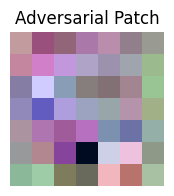

Attack Success Rate: 89.86%


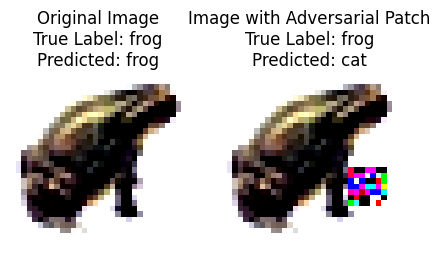

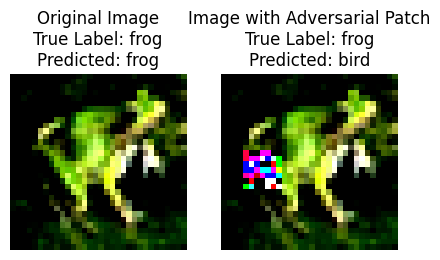


Training for patch size: (16, 16)
Epoch 1/20, Loss: 5.5230
Epoch 2/20, Loss: 4.5556
Epoch 3/20, Loss: 4.0172
Epoch 4/20, Loss: 3.7193
Epoch 5/20, Loss: 3.5286
Epoch 6/20, Loss: 3.4340
Epoch 7/20, Loss: 3.3364
Epoch 8/20, Loss: 3.2565
Epoch 9/20, Loss: 3.2083
Epoch 10/20, Loss: 3.1857
Epoch 11/20, Loss: 3.1528
Epoch 12/20, Loss: 3.1246
Epoch 13/20, Loss: 3.0894
Epoch 14/20, Loss: 3.0788
Epoch 15/20, Loss: 3.0534
Epoch 16/20, Loss: 3.0537
Epoch 17/20, Loss: 3.0331
Epoch 18/20, Loss: 3.0171
Epoch 19/20, Loss: 3.0038
Epoch 20/20, Loss: 2.9981
Visualizing patch of size (16, 16)


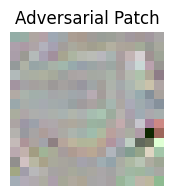

Attack Success Rate: 88.90%


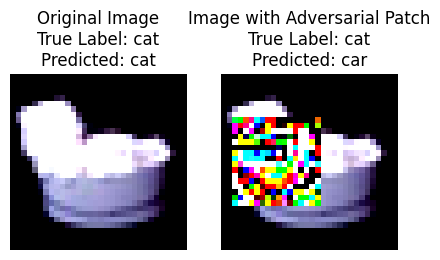

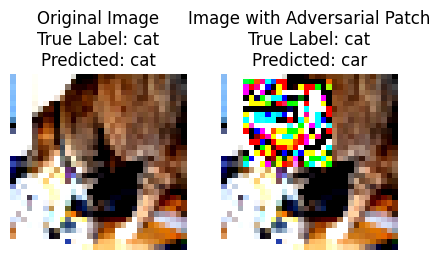

In [8]:
# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches of different sizes
for patch_size in patch_sizes:
    print(f"\nTraining for patch size: {patch_size}")
    patch = create_patch(patch_size)
    train_adversarial_patch(ResNet18, patch, target_class=None, num_epochs=20)

    # Save the patch
    torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}_untargeted.pth')

    # Visualize the patch
    print(f"Visualizing patch of size {patch_size}")
    visualize_patch(patch)

    # Evaluate attack success rate
    evaluate_patch(ResNet18, patch, test_loader)

    # Visualize misclassified examples with the adversarial patch
    visualize_misclassified_patched_images(ResNet18, patch, test_loader, classes, num_examples=2)
